# Generate training data by performing Metropolis-Hastings on the Ising Model

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

class IsingModel:
    
    def __init__(self, size, T = 1, J = 1, h = 0):
        self.size = size # size of lattice
        self.T = T # k_B * temperature (default 1)
        self.step = 0
        self.J = J # strength of interaction 
        self.h = h # strength of magnetic field
    
    def initialize(self):
        self.state = np.random.choice([-1, 1], (self.size, self.size))
        
    
    def update(self):
        r_ind, c_ind = np.random.choice(self.size, 2)
    
        energy = self.J * self.state[r_ind][c_ind]*(self.state[(r_ind-1)%self.size][c_ind] + \
                                            self.state[(r_ind+1)%self.size][c_ind] + \
                                            self.state[r_ind][(c_ind-1)%self.size] + \
                                            self.state[r_ind][(c_ind+1)%self.size])
        energy += -self.h * (self.state[r_ind][c_ind]) # generally absent
        
        prob = min(1, float(np.e**(-2*energy/self.T)))
        
        if np.random.random() < prob:
            self.state[r_ind][c_ind] *= -1
        
        self.step += 1
        
    def display(self):
        cmap = colors.ListedColormap(['blue', 'red'])
        bounds=[-1,0,1]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        plt.imshow(self.state, interpolation='nearest', origin='lower',
                    cmap=cmap, norm=norm)
        plt.title("Step : {}".format(self.step))

    

Generating data and appending to `data`

In [18]:
data = []
for _ in range(1000):
    i = IsingModel((10), 1)
    i.initialize()
    for _ in range(1000):
        i.update()
    data.append(i.state)
data = np.array(data)

# Restricted Boltzmann Machine class implementing Contrastive Divergence

In [213]:
class RBM:
    def __init__(self, data, visible_size, hidden_size, temp = 1, eta = 0.1):
        """
        visible_size: size of visible layer (Ising config)
        hidden_size: size of hidden layer
        temp: temperature
        """
        self.data = (data + 1) / 2 # turn Ising model from -1,1 to 0,1
        self.temp = temp
        self.datalen = data.shape[0] # number of Ising configs
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        self.params = {
            "w_ia": np.random.normal(0, 0.4, size=(visible_size, hidden_size)), # connection between visible and hidden unit
            "b_a": np.random.normal(0, 0.4, size=hidden_size), # bias of hidden units
            "a_i": np.random.normal(0, 0.4, size=visible_size) # bias of visible units
        }
        self.eta = eta # step size parameter 
        
    def sample_h_given_v(self, v):
        # Batch Dot product of data vector with connection parameters
        dot_prod = np.einsum('ij,ij->i', np.tile(v, (self.hidden_size, 1)), self.params["w_ia"].T)
        # Compute energy by adding bias
        energies = self.params["b_a"] + dot_prod
        # Compute probability hidden unit is on
        p_hidden = 1/(1 + np.exp(-energies / self.temp))
        # Sample hidden unit vector
        h = [np.random.choice([0, 1], p = [1 - prob_1, prob_1]) for prob_1 in p_hidden]
        return np.array(h)
    
    def sample_v_given_h(self, h):
        # Batch Dot product of hidden vector with connection parameters
        dot_prod = np.einsum('ij,ij->i', np.tile(h, (self.visible_size, 1)), self.params["w_ia"])
        # Compute energy by adding bias
        energies = self.params["a_i"] + dot_prod
        # Compute probability hidden unit is on
        p_visible = 1/(1 + np.exp(-energies / self.temp))
        # Sample hidden unit vector
        v = [np.random.choice([0, 1], p = [1 - prob_1, prob_1]) for prob_1 in p_visible]
        return np.array(v)
    
    def train(self):
        '''
        Run contrastive divergence
        '''
        
        # Sample visible unit vector
        v = self.data[np.random.randint(self.datalen)].flatten()
        
        # Sample hidden unit vector 
        h = self.sample_h_given_v(v)
        
        # Compute outer product 
        vh = np.outer(v, h)
        
        # Sample new visible vector
        v_prime = self.sample_v_given_h(h) 
        
        # Sample new hidden vector
        h_prime = self.sample_h_given_v(v_prime)
        
        # Compute outer product
        v_prime_h_prime = np.outer(v_prime, h_prime)
        # Update weights of RBM
        self.params["w_ia"] += self.eta * (vh - v_prime_h_prime)
        self.params["b_a"] += self.eta * (h - h_prime)
        self.params["a_i"] += self.eta * (v - v_prime)
        
        
    def sample(self, num_samples, thinning=10):
        """
        thinning: only take every `thinning` samples
        """
        v = np.random.choice([0, 1], size=(self.visible_size))
        samples = []
        
        for step in range(num_samples * thinning):
            h = self.sample_h_given_v(v)
            v = self.sample_v_given_h(h)
            if step % thinning == thinning - 1:
                samples.append(v)
                
        return samples

# Training the RBM using Contrastive Divergence
We print the distance between the original connection parameters and the final connection parameters.

In [218]:
import copy
rbm = RBM(data, 100, 20)
init_param = copy.deepcopy(rbm.params)
for _ in range(10000):
    rbm.train()
print(np.linalg.norm(init_param["w_ia"] - t["w_ia"]))

58.69343890239761


# Sampling from the trained RBM

We can see that the RBM generally produces samples that have non-zero magnetization, with clusters of 0 in between. If we run the model for many iterations, discarding the first samples (called the burn-in period), the equilibrium distribution of the RBM is a bit perplexing, since it has many 0s surrounded by all 1s, which should be very unstables in the equilibrium distribution. However, if we don't include the burn-in period, the model actually has good clusters of 0s, which makes more sense. I might have to investigate if there's a bug in my method.

[1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 1]


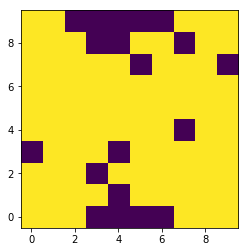

[1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1]


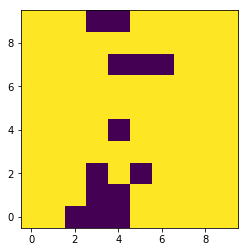

[1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0
 0 1 1 0 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 1 0 0 1 0]


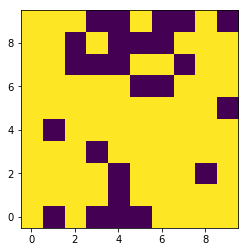

[1 1 0 1 0 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 0 1 0]


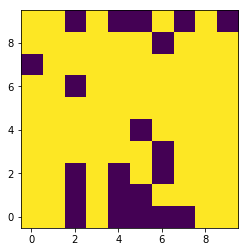

[1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0
 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1]


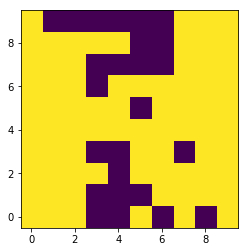

[1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1]


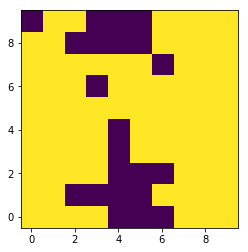

[1 1 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 1 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1]


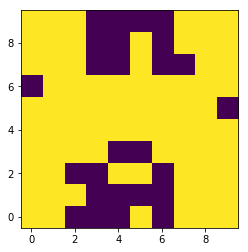

[0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1]


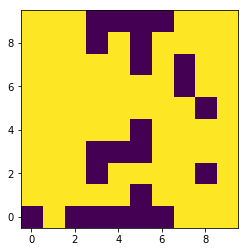

[1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1
 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 1]


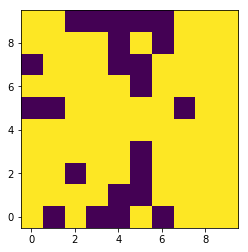

[1 0 1 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1]


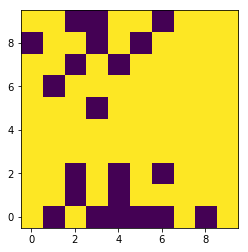

In [228]:
cmap = colors.ListedColormap(['blue', 'red'])
bounds=[0,1]
norm = colors.BoundaryNorm(bounds, cmap.N)
for im in rbm.sample(10, 10)[-10:]:
    print(im)
    plt.imshow(im.reshape(10,10), interpolation='nearest', origin='lower')
    plt.show()

[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


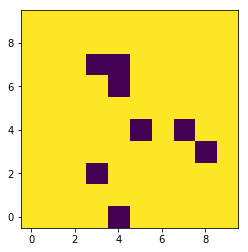

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]


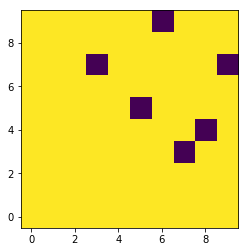

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1
 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1
 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


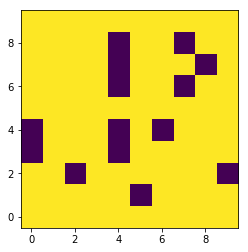

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


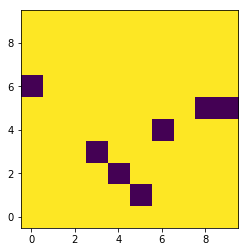

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1]


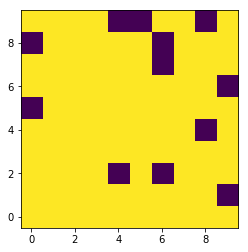

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


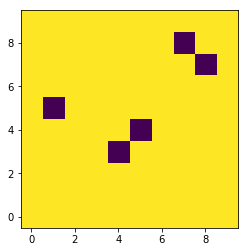

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1
 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]


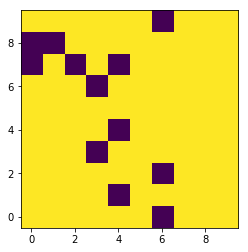

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1
 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1]


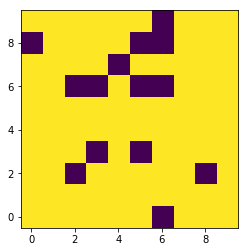

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1
 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1]


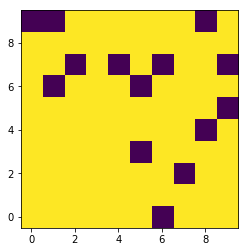

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]


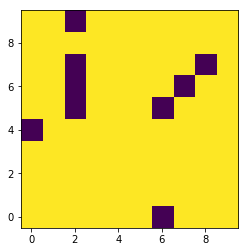

In [227]:
cmap = colors.ListedColormap(['blue', 'red'])
bounds=[0,1]
norm = colors.BoundaryNorm(bounds, cmap.N)
for im in rbm.sample(1000, 10)[-10:]:
    print(im)
    plt.imshow(im.reshape(10,10), interpolation='nearest', origin='lower')
    plt.show()